In [2]:
import os, sys
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
from scipy.signal import residue
import seaborn as sns
import random as rnd
from importlib import reload

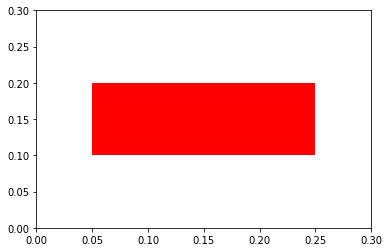

In [3]:
#res or res2
resdir = 'res2/'
import geometryproc
reload(geometryproc)
from geometryproc import Geometry
Geometry(resdir+'geometry.in', xlim=(0.0,0.3), zlim = (0.0, 0.3)).draw(show=True)

## Density Of States
One of the most important quantities of a resonance system is so-called density of states (DOS). In resonance systems density of states  describes the number of states per an interval of energy and can be calculated as 

Decomposing an electromagnetic field into an orthogonal functions, such as , DOS can be represented as a sum of Fourir coefficients in frequency domain.

$$
\begin{equation}
\operatorname{DOS}(\omega)=\sum_{n}|a_n(\omega)|^2
\end{equation}
$$

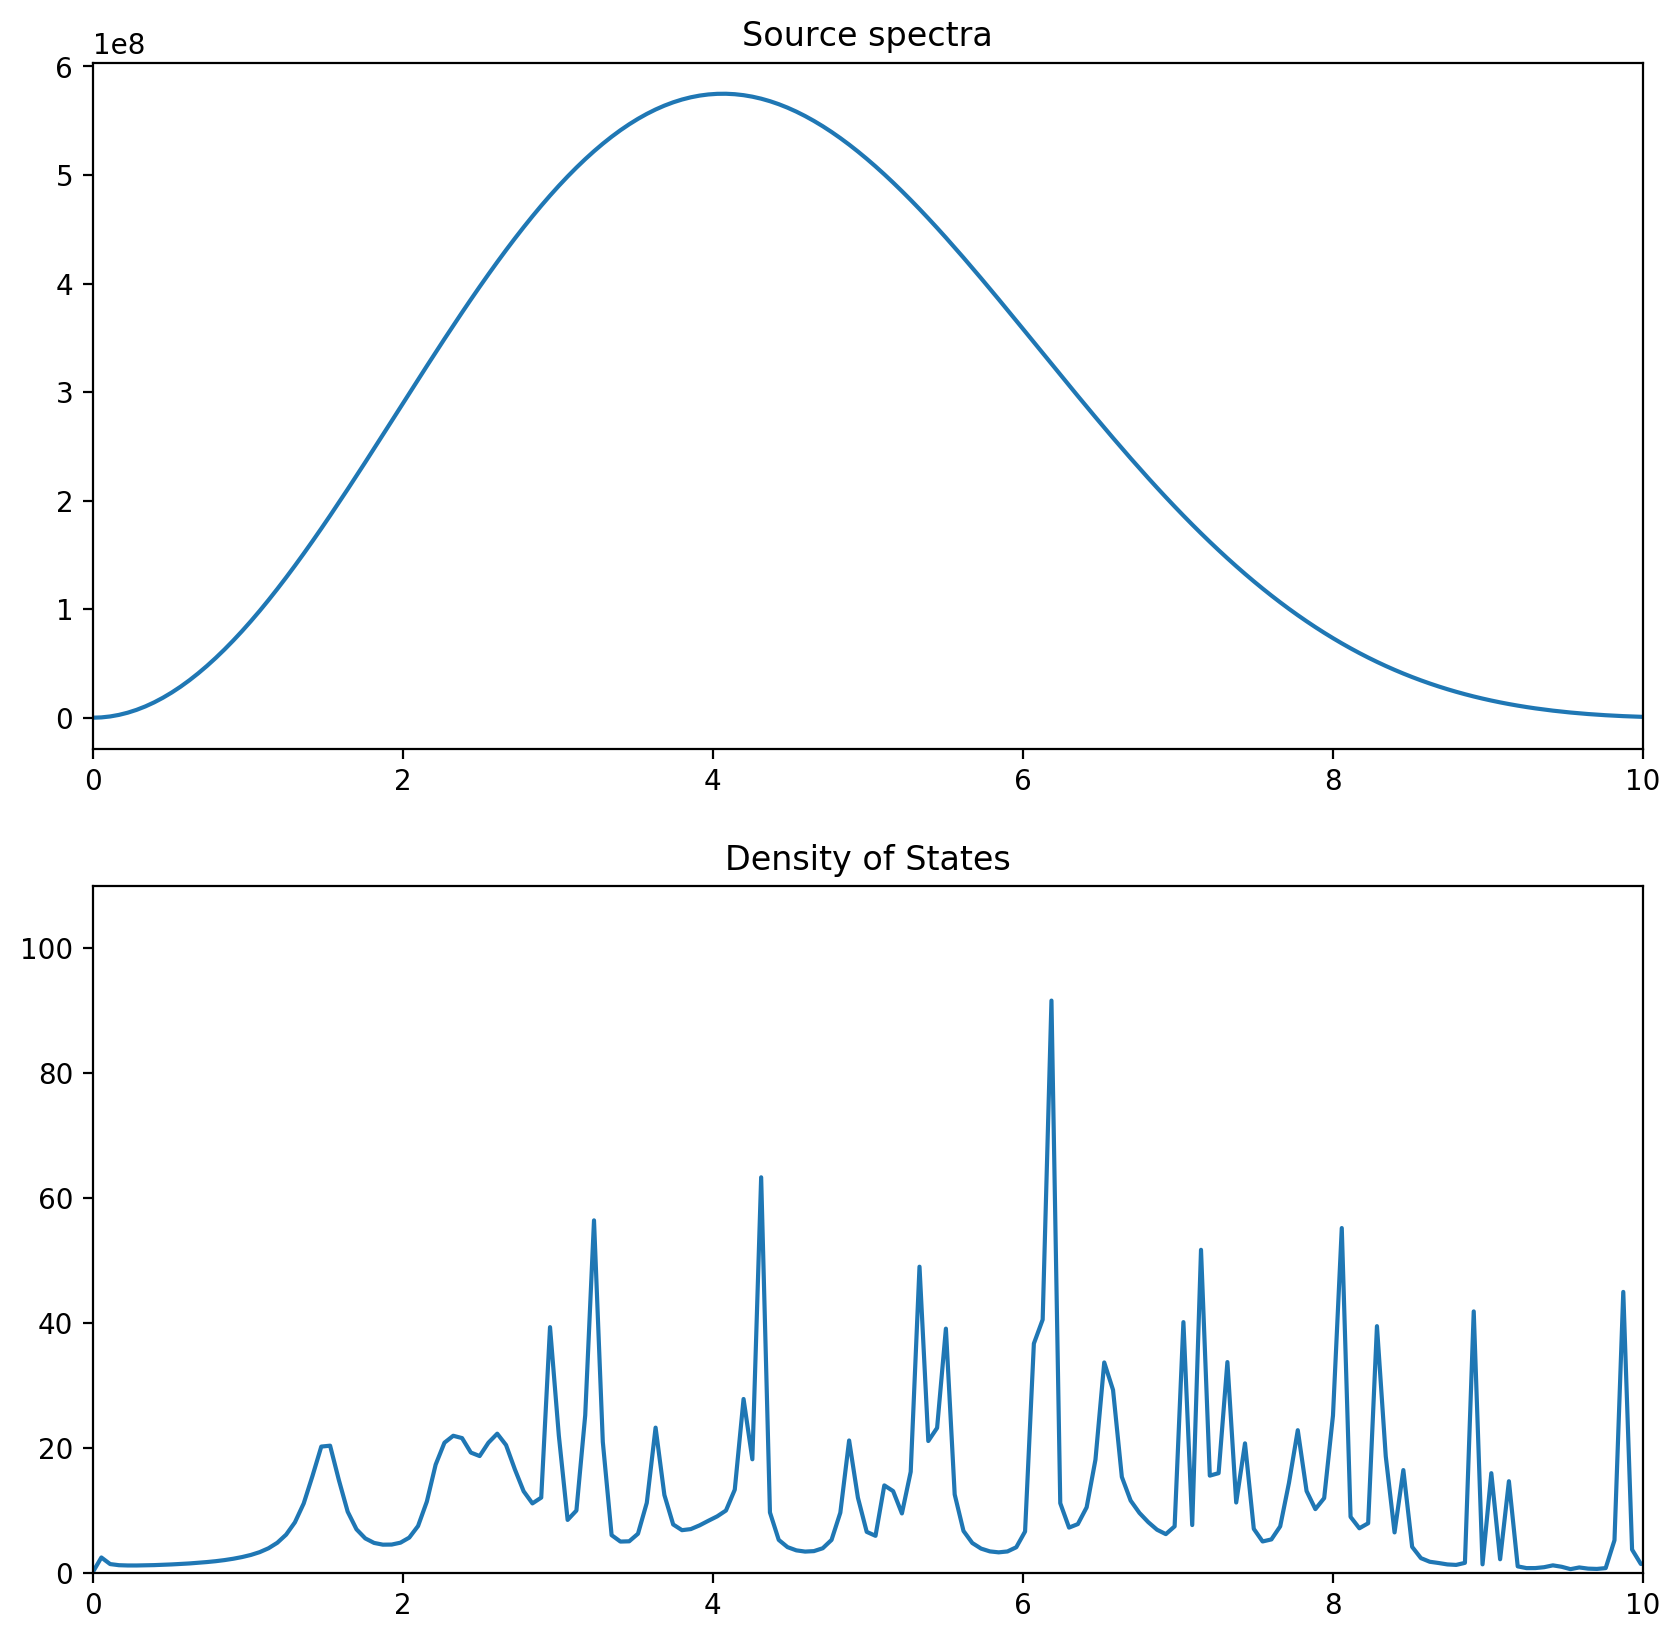

In [5]:
import fdtd_utils
reload(fdtd_utils)
from fdtd_utils import tdcmt
from fdtd_utils import myfun
from fdtd_utils import frac_fit
from fdtd_utils import exp_fit
fmax = 10
spectr=tdcmt(resdir+'src.bin',resdir+'ful.bin',1.17541e-12,50000)
plt.figure(figsize=(10,10), dpi=200)
plt.subplot(211)
plt.title('Source spectra')
plt.plot(spectr.f,spectr.pdss)
plt.xlim(0,fmax)
plt.subplot(212)
plt.title('Density of States')
plt.plot(spectr.f,spectr.dos)
mask = spectr.f < fmax
ymax = np.max(spectr.dos[mask])
plt.xlim(0,fmax)
plt.ylim(0, 1.2*ymax)
plt.show()

## Fitting 

Using rational polynomial expansion, it is useful to represent $a_k(\omega)$ coefficients in the following form

$$
\begin{equation}
a_k(\omega)=\frac{\sum_{i=0}^{n} c_{i} (j\omega )^{i}}{1+\sum_{i=1}^{m} d_{i} (j\omega)^{i}}
\end{equation}
$$



### Test

Let's try to fit rational function to see how fitting is going. 

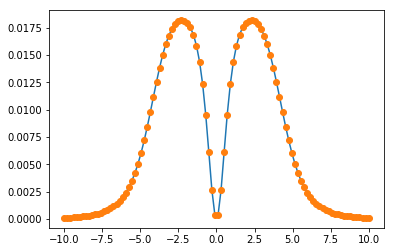

In [6]:
N=3 #2*N order of poly
M=100 #number of points
w=np.linspace(-10,10,M)
fun=(10j*w)/((1j*w)**4+100.*(1j*w)+5. + 5.*(1j*w-3)**2.+5)
a=frac_fit()
a.fit0(w,fun,0,N)
out=a.out(w)
plt.plot(w,np.abs(fun)**2)
plt.plot(w, np.abs(out)**2, 'o')
plt.show()

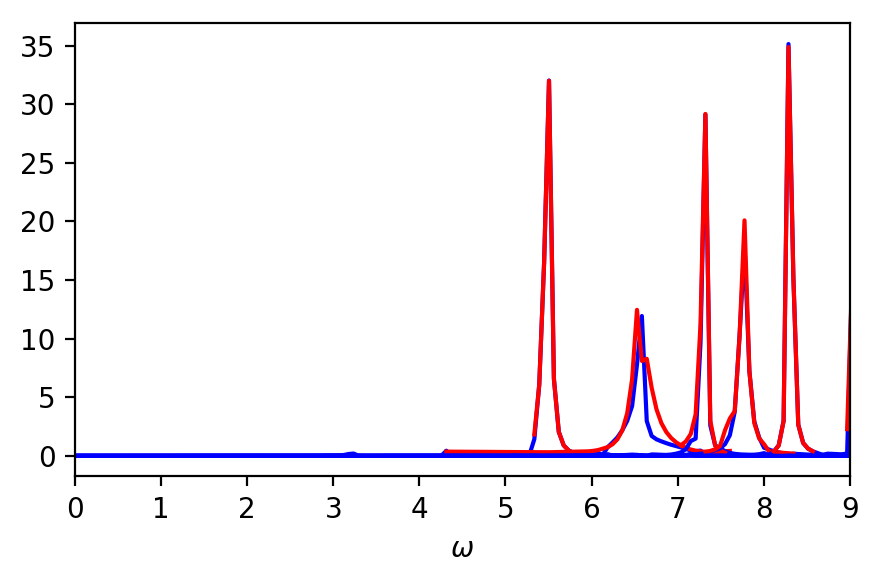

In [8]:
poles = 3
import fdtd_utils
reload(fdtd_utils)
from fdtd_utils import tdcmt
from fdtd_utils import myfun
from fdtd_utils import frac_fit
from fdtd_utils import exp_fit
spectr=tdcmt(resdir+'src.bin',resdir+'ful.bin',1.17541e-12,50000)
nmodes = spectr.smode.shape[1]
# randomly choose 6 modes to plot
modes = np.random.choice(np.arange(nmodes),size=6, replace=False)
modes.sort()
plt.figure(figsize=(5,3), dpi = 200)
plt.xlim(0,fmax-1)
#plt.ylim(0,12)
plt.xlabel('$\omega$')
#plt.title('modes %s' % str(modes))
for i in modes:
    spectr.fitone(i,0.1,fmax, N=poles)
plt.show()

In [36]:
spectr.a.a, spectr.a.b

(array([ -6.50491120e-08,   2.13620063e-07,  -1.41332897e-05,
          3.57673082e-05,  -9.72904164e-04,   1.45342151e-03,
         -2.09322501e-02]),
 array([  1.72384483e-06,  -2.43638277e-08,   4.36085456e-04,
         -1.61313708e-05,   3.63873198e-02,  -1.29121291e-03,
          1.00000000e+00]))

Using residue expansion, $a_k$ coefficients can be represented in the following form

$$a_n(\omega)=\frac{\sum_{i=0}^{n} c_{i} (j\omega )^{i}}{1+\sum_{i=1}^{m} d_{i} (j\omega)^{i}} = s (j\omega) + \sum\frac{C}{j\omega - \omega_0} + \frac{C^*}{j\omega - \omega_0^*}$$

Comparing it with a solution of coupled mode equation

$$
\begin{equation}
    a_n(\omega) = \sum_{k} \frac{C_k}{i(\omega - \Omega_k) + \Gamma_k}
\end{equation}
$$

it can be seen that $\Omega_k, \Gamma_k$ can be expressed from poles ($\omega_0$) of residue expansion.

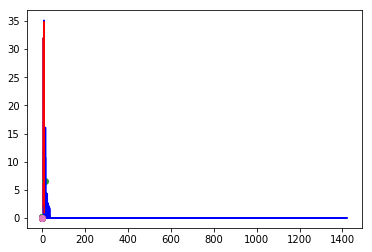

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
points = np.zeros((len(modes), 2*poles), dtype = np.complex)
import fdtd_utils
reload(fdtd_utils)
from fdtd_utils import tdcmt
from fdtd_utils import myfun
from fdtd_utils import frac_fit
from fdtd_utils import exp_fit
for i, mode in enumerate(modes):
    spectr=tdcmt(resdir+'src.bin',resdir+'ful.bin',1.17541e-12,50000)
    spectr.fitone(mode,0.1,10, N = poles, plot=False)
    A = spectr.a.a[:]
    B = spectr.a.b[:]
    p, g, k = residue(A, B)
    for pole, (re, im) in enumerate(zip(np.real(p), np.imag(p))):
        if im > 0:
            if im == 0:
                print(mode, pole)
            plt.plot(re, im, 'o')
            points[i, pole] = re + 1j*im
plt.show()

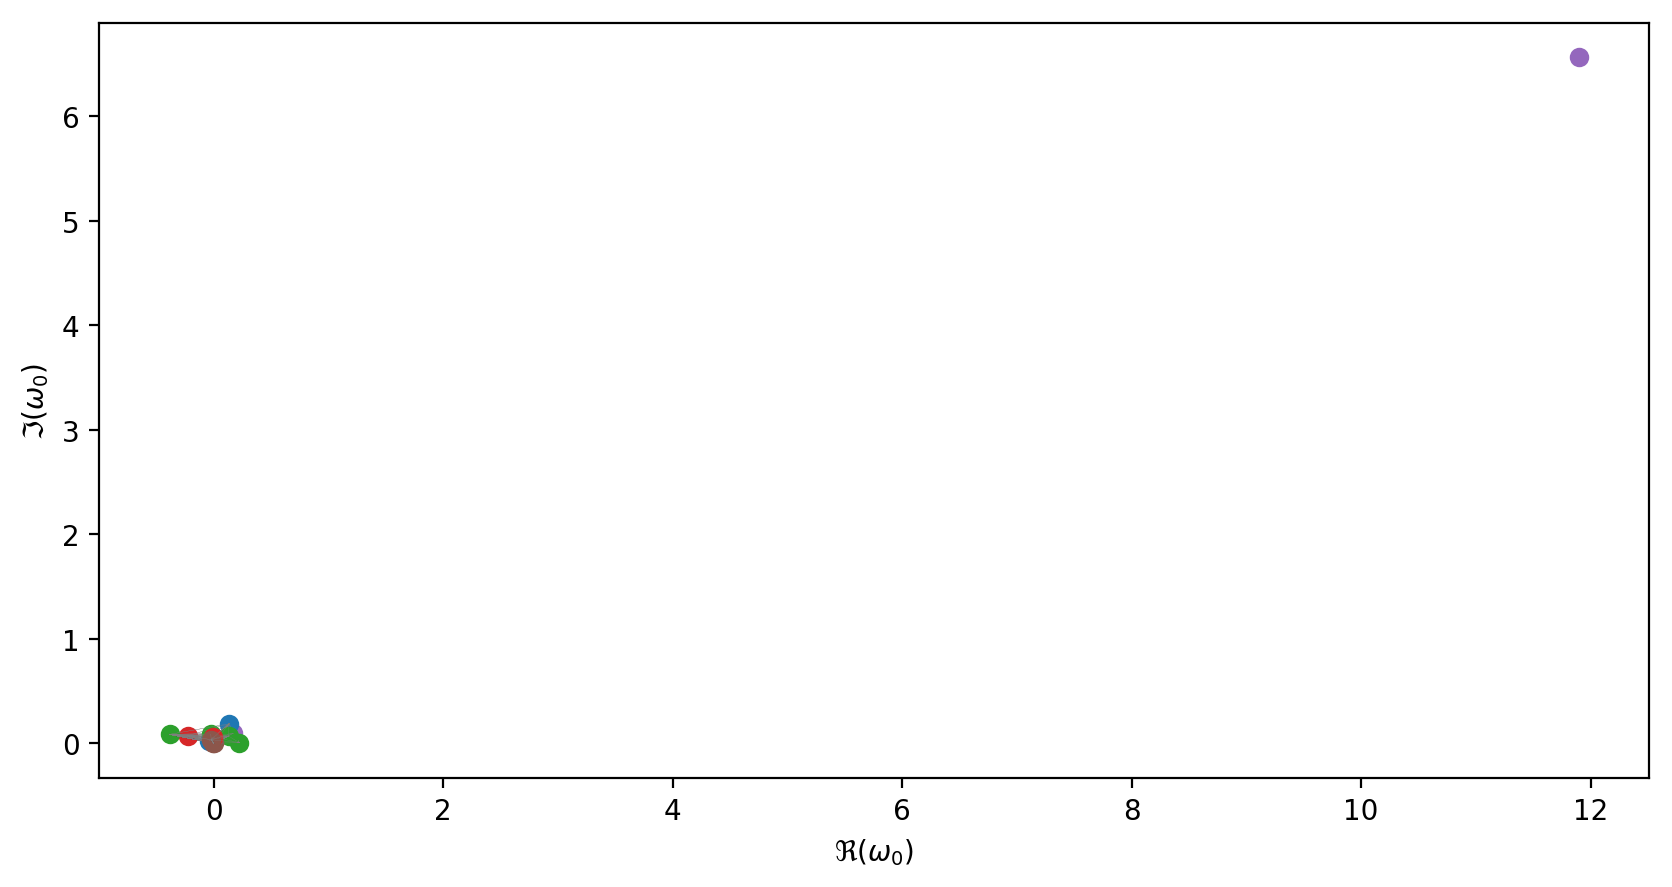

In [13]:
plt.figure(figsize=(10,5), dpi=200)
plt.xlabel(r'$\Re (\omega_0)$')
plt.ylabel(r'$\Im (\omega_0)$')
#distance treshold
dist_tresh = 0.4
for i, z1 in enumerate(np.nditer(points)):
    mode = i % len(modes)
    if z1 == 0j:
        continue
    y1 = np.imag(z1)
    x1 = np.real(z1)
    plt.plot(x1, y1, 'o', lw = 20, c = colors[mode])
    for z2 in np.nditer(points):
        y2 = np.imag(z2)
        x2 = np.real(z2)
        if np.linalg.norm([0.3*(x1-x2),(y1-y2)]) < dist_tresh:
            plt.plot((x1,x2),(y1,y2), color = 'gray', linewidth = 0.1)
plt.show()

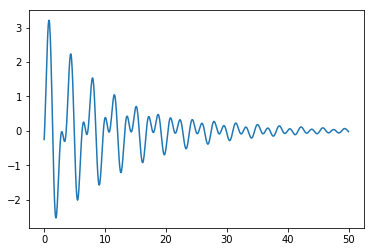

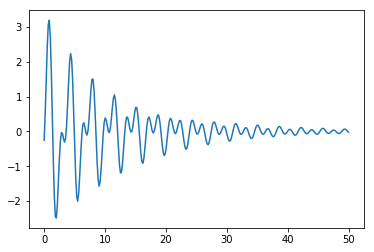

In [15]:
# exponential fittings
# #test
x=np.linspace(0,50,1000)
y=1.4*np.cos(3.5*x-math.pi)*np.exp(-x/15.)+2.3*np.cos(1.8*x-math.pi/3.)*np.exp(-x/10.)
plt.plot(x,y)


dx=x[1]-x[0]
a=exp_fit()
a.mtm(y,4,dx)

x=np.linspace(0,50,300)
out=a.model(x)
plt.plot(x, out)
plt.show()

In [18]:
p0 = 0.0
def rational(x, p, q):
    """
    The general rational function description.
    p is a list with the polynomial coefficients in the numerator
    q is a list with the polynomial coefficients (except the first one)
    in the denominator
    The zeroth order coefficient of the denominator polynomial is fixed at 1.
    Numpy stores coefficients in [x**2 + x + 1] order, so the fixed
    zeroth order denominator coefficent must comes last. (Edited.)
    """
    return np.abs(np.polyval(p + [p0], 1j*x) / np.polyval(q + [1.0], 1j*x))

def rational3_3(x, p1, p2, q1, q2):
    return rational(x, [p1, p2], [q1, q2])
f=spectr.f
mask = f < 50
w = f[mask][1:]
fun=np.abs(mode[mask,4][1:])
popt, pcov = curve_fit(rational3_3, w, fun, maxfev = 1000000)
print(popt)

plt.plot(w, fun**2, label='original')
plt.plot(w, rational3_3(w, *popt)**2, label='fit')
plt.show()

TypeError: 'int' object is not subscriptable